# Google Colab code

## Repo setup

In [ ]:
# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Locate relevant folder
%cd drive/My Drive/COVID19-DVRN/Project-13-GColab

/content/drive/My Drive/COVID19-DVRN/Project-13-GColab


In [ ]:
# Clone repo if not cloned already
! git clone https://github.com/COVID19-DVRN/P_13a-Public-sentiment-toward-government-handling-of-COVID-19-and-treatment-of-the-incarcerated-

Cloning into 'P_13a-Public-sentiment-toward-government-handling-of-COVID-19-and-treatment-of-the-incarcerated-'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 223 (delta 18), reused 34 (delta 9), pack-reused 175
Receiving objects: 100% (223/223), 44.01 MiB | 10.67 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Checking out files: 100% (107/107), done.


In [ ]:
# Check out the relevant branch; modify if necessary
!cd P_13a-Public-sentiment-toward-government-handling-of-COVID-19-and-treatment-of-the-incarcerated- #&& git checkout topic-modeling

## Colab package installation

In [ ]:
# Required downloads on google colab
import nltk
# nltk.download('punkt') # sentence tokenizer
# |nltk.download('stopwords')
# nltk.download('wordnet')
nltk.download('popular') # alternative to grab most stuff
! pip install corextopic

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

## Filepaths

In [ ]:
# Switch to notebook's usual folder
import os
os.chdir('P_13a-Public-sentiment-toward-government-handling-of-COVID-19-and-treatment-of-the-incarcerated-/notebooks/')

# Notebook setup

In [ ]:
import os
os.chdir('..')

In [ ]:
# news_path = 'data/cleaned_text/states_full.csv'
news_path = '../../../../Shared drives/COVID-19 Dispersed Volunteer Research Network/Datasets/MediaCloud/incarceration/articles_scored.csv' # news data on GDrive

# Original version
preprocessed_pickle_path = 'big-data/original/preprocessed.pkl'
w2v_model_path = 'big-data/original/w2v_model.pkl'

# Modeling sentences
sentences_story_id_path = 'big-data/modelling-sentences/sentences-story-ids.csv'
sentences_preprocessed_pickle_path = 'big-data/modelling-sentences/preprocessed.pkl'
sentences_preprocessed_lst_pickle_path = 'big-data/modelling-sentences/preprocessed_lst.pkl'
sentences_w2v_model_path = 'big-data/modelling-sentences/w2v_model.pkl'

# Topic model
topic_model_filepath = '../topic_model.pkl'

# Dtm sparse
dtm_filepath = '../dtm_binary_sparse.pkl'

# Packages and Presets

In [ ]:
# auxiliary
import numpy as np
import pandas as pd
import copy
import time
import pickle
from tqdm._tqdm_notebook import tqdm_notebook
import re
tqdm_notebook.pandas() # progress bar

# Analytics
import gensim
import geotext_custom # for location analysis
from sklearn.decomposition import NMF # Faster topic modeling
from sklearn.decomposition import TruncatedSVD # SVD for sparse matrices
import seaborn as sns
import nltk
stopwords = nltk.corpus.stopwords.words('english')

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Custom package
import nlp.preprocessing as prep

pd.set_option('display.max_rows', 8)

from corextopic import corextopic as ct

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Prep

In [ ]:
news = pd.read_csv(news_path, encoding = "ISO-8859-1")
# revised column names for new news file
news['text_clean'] = news['text_clean'].fillna('').astype(str)
news['publish_date'] = pd.to_datetime(news['publish_date'])

In [ ]:
# Split sentences that we'll topic-model
news['new_text_sentence_lst'] = news['text_clean'].progress_apply(
    lambda x: nltk.tokenize.sent_tokenize(x))

In [ ]:
sentence_list = []
sentence_article_ids = []
for e, lst in enumerate(news['new_text_sentence_lst']):
    for sentence in lst:
        sentence_list.append(sentence)
        sentence_article_ids.append(news['stories_id'][e])
    if e % 1000 == 0:
        print(e)
sentence_article_ids = np.array(sentence_article_ids)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [ ]:
sentence_list_pd = pd.DataFrame(sentence_list, columns=['sentence'])
sentence_list_pd['stories_id'] = sentence_article_ids
sentence_list_pd['sentence_id'] = np.arange(len(sentence_list_pd))

story_sentence_counts = sentence_list_pd.groupby('stories_id').aggregate('count').reset_index()
story_sentence_counts = story_sentence_counts.rename({'sentence':'sentence_count'}, axis=1)

In [ ]:
# sentence_list_pd.to_csv(sentences_story_id_path, index=False)

# sentence_list_pd = pd.read_csv(sentences_story_id_path)

## NLP Preprocessing

In [ ]:
# function to perform lemmatize and stem preprocessing steps on the data set.
t = time.time()
# preprocessor = prep.Preprocessor(news['new_text_places_removed'])
preprocessor = prep.Preprocessor(sentence_list_pd['sentence'])
preprocessor.preprocess(lemmatize=True, # stopwords=, 
                        min_token_length=3)
print(time.time() - t)

107.93235158920288


In [ ]:
t = time.time()
preprocessor.get_bigrams_from_preprocessed()
print(time.time() - t)

27.505901098251343


In [ ]:
t = time.time()
preprocessor.create_nlp_items_from_preprocessed_df(no_below=2, verbose=True)

dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
                                                             preprocessor.bow_corpus_,
                                                             preprocessor.tfidf_,
                                                             preprocessor.corpus_tfidf_,
                                                             preprocessor.tfidf_sparse_)
print(time.time() - t)

0 arrest
1 expos
2 hold
3 inmat
4 jail
5 novel_coronavirus
6 offic
7 possibl
8 prior
9 quarantin
10 tell

 81668 unique words. 

45630 unique words after extremes filtered. 


Word 30 ("coronavirus") appears 1 time.
Word 34 ("infect") appears 1 time.
Word 71 ("confirm") appears 1 time.
Word 125 ("prison") appears 1 time.
Word 224 ("institut") appears 1 time.
Word 522 ("guard") appears 1 time.
Word 573 ("administr") appears 1 time.
Word 14102 ("thirteen") appears 1 time.

 Corpus TF-IDF preview:
[(0, 0.3060926898340096),
 (1, 0.3486431987179276),
 (2, 0.26635813719935775),
 (3, 0.10768646942997342),
 (4, 0.14460247247127025),
 (5, 0.357049222098509),
 (6, 0.2198018771260972),
 (7, 0.30151285836705366),
 (8, 0.4150791265692806),
 (9, 0.24087466146579223),
 (10, 0.26719910749594195),
 (11, 0.3359890093085214)]
42.23983430862427


In [ ]:
## VERSION 1
# f = open(preprocessed_pickle_path, "wb") # remember to open the file in binary mode
# pickle.dump(preprocessor, f)
# f.close()

# preprocessor = pickle.load(preprocessed_pickle_path)

# dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
#                                                              preprocessor.bow_corpus_,
#                                                              preprocessor.tfidf_,
#                                                              preprocessor.corpus_tfidf_,
#                                                              preprocessor.tfidf_sparse_)


## VERSION 2
# f = open(sentences_preprocessed_pickle_path, "wb") # remember to open the file in binary mode
# pickle.dump(preprocessor, f)
# f.close()

# with open(sentences_preprocessed_pickle_path, 'rb') as pickle_file:
#     preprocessor = pickle.load(pickle_file)

# dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
#                                                              preprocessor.bow_corpus_,
#                                                              preprocessor.tfidf_,
#                                                              preprocessor.corpus_tfidf_,
#                                                              preprocessor.tfidf_sparse_)

In [ ]:
terms = list(dictionary.token2id.keys())

# Topic Modeling

Semi-supervised modeling
* https://medium.com/pew-research-center-decoded/overcoming-the-limitations-of-topic-models-with-a-semi-supervised-approach-b947374e0455

NMF notes:
* https://github.com/derekgreene/topic-model-tutorial

## CoRex

### Setup

Matrix setup

In [ ]:
from scipy.sparse import csr_matrix, find
from scipy import sparse

def sparse_where(mask, val, arr):
    """ Sparse `np where` """
    out = arr.copy()
    rows, cols, _ = find(mask)
    for r, c in zip(rows, cols):
        out[r, c] = val
    return out

# # Create binary matrix
# matrix = sparse.csr_matrix(np.array([0, 1, 0, 1]))
# x_s, y_s, t_fs = find(matrix > 0)
# sparse_where(matrix > 0, 66, x).todense()

t = time.time()
dtm_binary_sparse = sparse_where(tfidf_sparse > 0, 1, tfidf_sparse)
print(time.time() - t)

# Get word list
words = [dictionary[e] for e in range(len(dictionary))]

213.1625702381134


In [ ]:
# Pickle and dump sparse matrix
f = open(dtm_filepath, "wb")
pickle.dump(dtm_binary_sparse, f)
f.close()

In [ ]:
# Load sparse matrix when needed
infile = open(dtm_filepath,'rb')
dtm_binary_sparse = pickle.load(infile)
infile.close()

Define terms

In [ ]:
def find_sum(word, words, dtm_sparse):
  index = np.argwhere(word == np.array(words))[0][0]
  sentence_count = dtm_sparse[:,index].count_nonzero()
  print(sentence_count)

def find_matches(regex_input, lst):
  r = re.compile(regex_input)
  matches = list(filter(r.match, lst))
  return matches

find_sum('nonviol_offens', words, dtm_binary_sparse)
print(dtm_binary_sparse.shape[0])
print(find_matches('.*viol.*', words)[0:10])

244
402090
['violenc', 'violent', 'violat_michigan', 'penalti_violat', 'violat', 'nonviol', 'corruptionâ_violenc', 'violent_crime', 'violent_offens', 'nonviol_offens']


In [ ]:
print(find_matches('nonviol.*', words))
print(find_matches('viole.*', words))
print(find_matches('.*health.*', words))
print(find_matches('.*reform.*', words))
print(find_matches('.*releas.*', words))

['nonviol', 'nonviol_offens', 'nonviol_crime', 'nonviol_offend', 'nonviol_level', 'nonviol_teen', 'nonviol_feloni', 'nonviol_nonsexu', 'nonviol_behav', 'nonviol_offendersâ']
['violenc', 'violent', 'violent_crime', 'violent_offens', 'violent_offend', 'violent_offenc', 'violenc_colombian', 'violenc_latin', 'violenc_misconduct', 'violent_habitu', 'violent_classifi', 'violenc_poverti', 'violenc_persecut', 'violent_margin', 'violent_ohman', 'violenc_profess', 'violenc_heinous', 'violenc_felon', 'violenc_sheriff', 'violent_coward', 'violent_spar', 'violent_domin', 'violent_forget', 'violent_troublemak', 'violenc_contra']
['health', 'ukraineâ_health', 'healthcar_profession', 'healthcar', 'healthcar_shoddi', 'young_healthi', 'healthi', 'older_unhealthi', 'healthi_safe', 'health_well', 'underli_health', 'health_villanova', 'mental_health', 'healthcar_worker', 'healthcar_provid', 'dcra_health', 'domoniqu_healthcar', 'healthcar_perspect', 'litani_health', 'wbts_health', 'healthâ', 'salari_healthc

In [ ]:
find_sum('nonviol_offens', words, dtm_binary_sparse)
find_sum('nonviol_offend', words, dtm_binary_sparse)
find_sum('nonviol_feloni', words, dtm_binary_sparse)
find_sum('nonviol_crime', words, dtm_binary_sparse)
find_sum('nonviol', words, dtm_binary_sparse)
find_sum('nonviol_misdemeanor', words, dtm_binary_sparse)
###
find_sum('violent', words, dtm_binary_sparse)
find_sum('violent_offens', words, dtm_binary_sparse)
find_sum('violent_offend', words, dtm_binary_sparse)
find_sum('violent_crime', words, dtm_binary_sparse)

140
339
16
114
627
21
793
180
406
302


**Terms for Topic Modelling (Divya)**

* Violent criminal 
* Non-violent criminal
* Early release
* Release 
* Home confinement
* Reform
* Prisoner health
* Inmate health
Added terms:
* Bail
* Home monitoring

Facility mentioned: prison, jail, solitary, detention

Mention of the federal guidelines: BOP, DOJ

---
**Revision for CoRex**

Hierarchy
* Health Y/N
  * Reform Y/N 
    * Release Y/N
* Search terms:
  * Facility searches: prison, jail, solitary, detention
  * Release type: search term mention of bail, home monitoring
  * Violent criminal type



In [ ]:
## This code isn't working properly
# combinations = np.array(combinate([[0, 1], [0, 1], [0, 1]])).T.tolist()

# term_groups = [health_terms, reform_terms, release_terms]
# term_lists = []
# for c in combinations:
#   term_list = []
#   for eC, signal in enumerate(c):
#     if signal == 1:
#       t = term_groups[eC]
#       for w in t:
#         term_list.append(w)
#   if len(term_list) > 0:
#     term_lists.append(term_list)

# term_lists = term_lists * 2

# for i in range(5):
#   term_lists.append([])


# for e, i in enumerate(term_lists):
#   print(str(e) + ': ' + str(i))

### Model training

#### First test terms

In [ ]:
# Topics
health_terms = ['health', 'healthcar']
reform_terms = ['reform', 'justic_reform']

# Search terms
release_terms = ['releas']
violent_terms = ['violent', 'violent_offend', 'violent_offens', 'violent_crime']
nonviolent_terms = ['nonviol_offens', 'nonviol_offend', 'nonviol_feloni', 'nonviol_crime']

# Manually defined term_lists
term_lists = [
 ['health', 'healthcar'],
 ['reform', 'justic_reform'],
 ['health', 'healthcar',      'reform', 'justic_reform']
]
n_topics = 20
for i in range(n_topics - len(term_lists)):
  term_lists.append([])

In [ ]:
def combinate(list_of_lists):
  new_list_of_lists = []
  lengths = [len(item) for item in list_of_lists]
  for e, item in enumerate(list_of_lists):
    if e != len(list_of_lists) - 1:
      repeater = np.prod(lengths[e+1:])
    else:
      repeater = 1
    if e != 0:
      tiler = np.prod(lengths[:e])
    else:
      tiler = 1
    new_item = np.tile(
        np.repeat(item, repeater), tiler
    )
    new_list_of_lists.append(new_item)

  return new_list_of_lists

#### Model 1

In [ ]:
t = time.time()
# Train the CorEx topic model (test)
# First layer
topic_model = ct.Corex(n_hidden=n_topics, seed=25)  # Define the number of latent (hidden) topics to use.
topic_model.fit(dtm_binary_sparse, words=words,
                anchors=term_lists,
                anchor_strength=3)
print(time.time() - t)

383.34682273864746


We use the below graph as a starting point for the number of topics we should use. But note that the distribution of the graph changes with ntopics, and so some iteration is required.

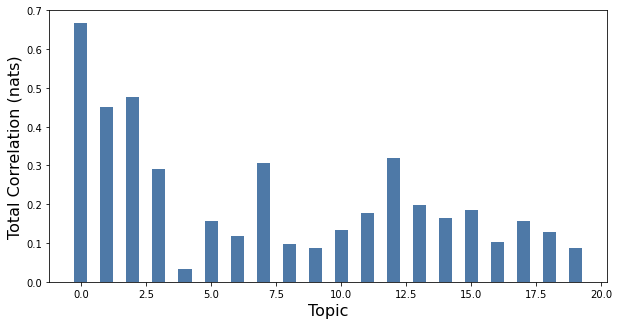

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

#### Final model

In [ ]:
# Manually defined term_lists
term_lists = [
 ['health', 'healthcar'],
 ['reform', 'justic_reform'],
 ['health', 'healthcar',      'reform', 'justic_reform']
]
n_topics = 6
for i in range(n_topics - len(term_lists)):
  term_lists.append([])

In [ ]:
t = time.time()
# Train the CorEx topic model (test)
# First layer
topic_model = ct.Corex(n_hidden=len(term_lists), seed=25)  # Define the number of latent (hidden) topics to use.
topic_model.fit(dtm_binary_sparse, words=words,
                anchors=term_lists,
                anchor_strength=3)
print(time.time() - t)

163.33305382728577


In [ ]:
# Train a second layer to the topic model; not fully explored yet
t = time.time()
tm_layer2 = ct.Corex(n_hidden=12)
tm_layer2.fit(topic_model.labels)
print(time.time() - t)

33.545870780944824


In [ ]:
from corextopic import vis_topic as vt
vt.vis_hierarchy([topic_model, tm_layer2],
                 column_label=words, max_edges=70)

weight threshold is 0.000000 for graph with max of 70.000000 edges 


AttributeError: ignored

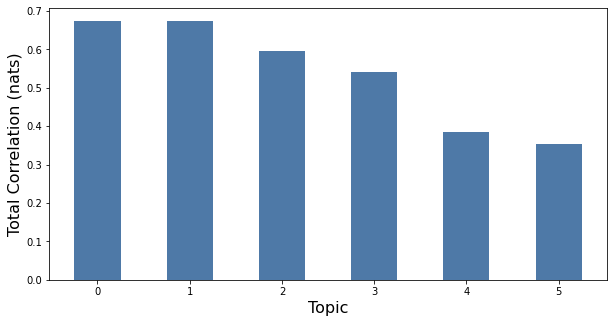

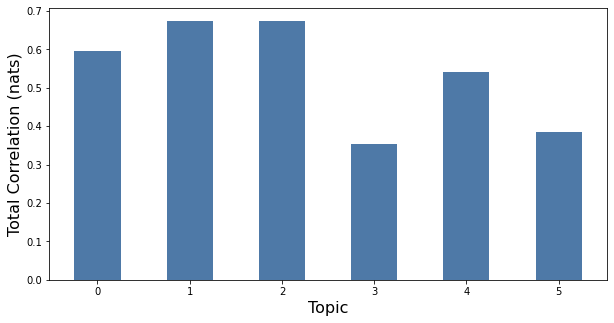

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), np.sort(topic_model.tcs)[::-1], color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.show()

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

### Model Dump

In [ ]:
# Pickle and dump model
f = open(topic_model_filepath, "wb")
pickle.dump(topic_model, f)
f.close()

In [ ]:
# Load model when needed
infile = open(topic_model_filepath,'rb')
topic_model = pickle.load(infile)
infile.close()

Six topic model seems to be:
0. Healthcare (anchored)
1. Reform (anchored)
2. Healthcare and reform (anchored)
3. A loose topic: requires further subdivision
4. COVID in prisons (spread and policy reactions to it)
5. Region-specific trends

In [ ]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: health,public,depart,care,healthcar,safeti,human_servic,risk,public_safeti,servic
1: court,releas,sentenc,judg,order,charg,serv,attorney,convict,file
2: health,reform,healthcar,local,especi_older,condit,advoc,includ_pneumonia,problem_caus,manag_practic
3: test,posit,social_distanc,famili,peopl,communiti,like,need,safe,allow
4: prison,correct,inmat,coronavirus,covid,facil,state,case,feder,counti
5: santa_clara,jail,santa_rita,sheriffâ_offic,alameda_counti,moder_symptom,caus_mild,hawk_sawyer,protest_outsid,california_institut


In [ ]:
topic_model.get_topics(20)[3]

[('test', 0.04626523849332951),
 ('posit', 0.04387123611820142),
 ('social_distanc', -0.01702204465349403),
 ('famili', -0.015704372062703316),
 ('peopl', -0.01293572339037496),
 ('communiti', -0.010920680728962304),
 ('like', -0.008893677351300458),
 ('need', -0.00848207901427798),
 ('safe', -0.00796128632984989),
 ('allow', -0.007824876896799027),
 ('incarcer', -0.007488911716267249),
 ('mask', -0.007181988843788415),
 ('provid', -0.007041878251334837),
 ('live', -0.006867298660084586),
 ('think', -0.00654537066548281),
 ('space', -0.006370426939775229),
 ('right', -0.0061244885292690435),
 ('time', -0.005838185628721925),
 ('thing', -0.0055471972254043595),
 ('tri', -0.005389966640802609)]

## Graphs

In [ ]:
sentence_topic_ids = np.argmax(topic_model.p_y_given_x, axis=1)

sentence_topics = copy.deepcopy(sentence_list_pd)
sentence_topics['topic'] = sentence_topic_ids
sentence_topics = sentence_topics.merge(story_sentence_counts, on='stories_id', how='left')
sentence_topics = sentence_topics.merge(news[['publish_date', 'stories_id']], on='stories_id', how='left')
sentence_topics['normalized'] = 1 / sentence_topics['sentence_count']
sentence_topics = sentence_topics.sort_values(by='publish_date')

sentence_topics = sentence_topics.drop_duplicates(subset='sentence_id_x')
sentence_topics = sentence_topics.drop('sentence_id_x', axis=1)
sentence_topics = sentence_topics.rename({'sentence_id_y':'sentence_id'}, axis=1)
sentence_topics

,sentence,stories_id,topic,sentence_count,sentence_id,publish_date,normalized
46593,"Overall, some 908 people have died of the viru...",1545473163,3,15,15,2020-01-15 00:00:00+00:00,0.066667
46581,The inmate reportedly told jail officials that...,1545473163,4,15,15,2020-01-15 00:00:00+00:00,0.066667
46582,RELATED: Some San Antonio residents are in sel...,1545473163,5,15,15,2020-01-15 00:00:00+00:00,0.066667
46583,"""Since the claim was made, we want to make sur...",1545473163,3,15,15,2020-01-15 00:00:00+00:00,0.066667
...,...,...,...,...,...,...,...
344670,EMBED >More News Videos The ABC7 I-Team looked...,1599851898,4,4,4,NaT,0.250000
344671,CHICAGO (WLS) -- A fourth Cook County Jail det...,1599851898,3,4,4,NaT,0.250000
344672,The 42-year-old also died at Stroger Hospital....,1599851898,4,4,4,NaT,0.250000
344673,"Of the nearly 400 cases, 215 detainees are cur...",1599851898,3,4,4,NaT,0.250000


### Basic exploration

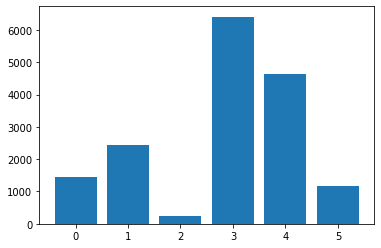

,topic,normalized
3,3,6406.547300
4,4,4646.038331
1,1,2449.147243
0,0,1455.375586
5,5,1162.896562
2,2,238.994977


In [ ]:
topic_totals = sentence_topics[['topic', 'normalized']].groupby('topic').aggregate(sum).reset_index()
topic_totals = topic_totals.sort_values(by='normalized', ascending=False)

plt.bar(topic_totals['topic'], topic_totals['normalized'])
plt.show()

topic_totals[0:8]

In [ ]:
subset = sentence_topics[sentence_topics['topic'] == 4]
for i in np.random.choice(subset['sentence'], 10):
  print(i)

Those three new cases, reported in a five-day span, bring the county jail systemâs total of past and present virus infections to six since mid-March.
Documents provided to The Times show state prisons have been locking down cell blocks where inmates exhibit flu-like symptoms.
The inmate, who is housed at the Metropolitan Detention Center in Brooklyn, complained of chest pains on Thursday, a few days after he arrived at the facility, the federal Bureau of Prisons told The Associated Press.
"Pursuant to employee privacy rights, we are unable to respond to your request for information on the subject of staff death due to COVID-19," Bull said in an email requesting an interview for this story.
A prison near Coldwater is dealing with a coronavirus outbreak, and five inmates at Lakeland Correctional Facility have died after contracting it.
Prisoners are making splatter masks, surgical masks, gowns and hand sanitizer to address some of the need.
"If we do have an outbreak or an incident, we

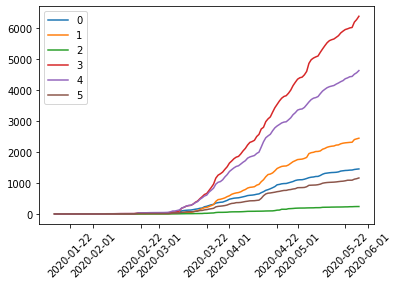

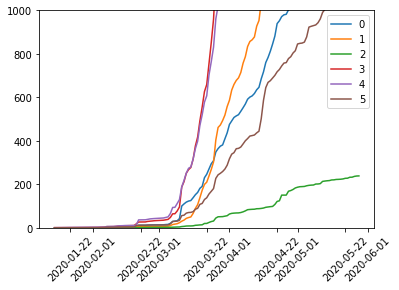

In [ ]:
# Don't show warnings
import warnings
def action_with_warnings():
    warnings.warn("should not appear")

def plt_stuff():
  with warnings.catch_warnings(record=True):

    for t in np.arange(np.max(sentence_topics['topic']) + 1):
      subset = sentence_topics[sentence_topics['topic'] == t]
      subset['date'] = subset['publish_date'].dt.date
      subset_aggregate = subset[['date', 'normalized']].groupby('date').aggregate(sum).reset_index()
      plt.plot(subset_aggregate['date'], np.cumsum(subset_aggregate['normalized']), label=t) # cumsum
      #plt.plot(subset_aggregate['date'], subset_aggregate['normalized']) # daily
      plt.legend()

    # plt.yscale('log')
    plt.xticks(rotation=45)

plt_stuff()
plt.show()

plt_stuff()
plt.ylim(0, 1000)
plt.show()

## Topic search term exploration

* Violent criminal 
* Non-violent criminal
* Early release
* Release 
* Home confinement
* Reform
* Prisoner health
* Inmate health
Added terms:
* Bail
* Home monitoring

In [ ]:
def find_sentence_matches(regex_, wordlist):
  matches = find_matches(regex_, wordlist)
  match_ids = np.array([e for e, w in enumerate(wordlist) if w in matches])
  return match_ids

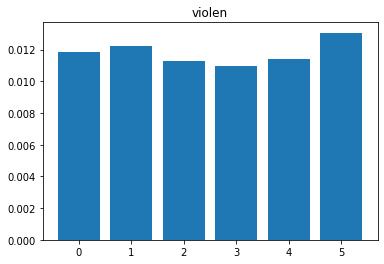

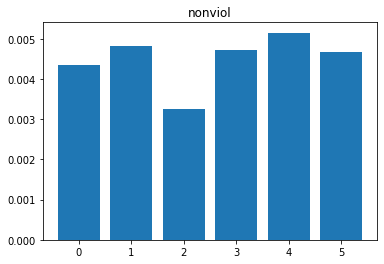

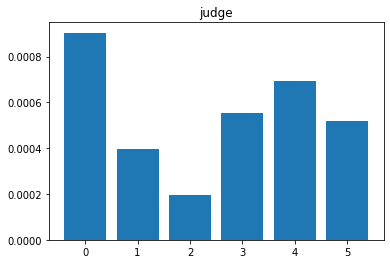

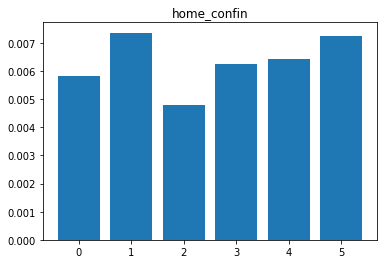

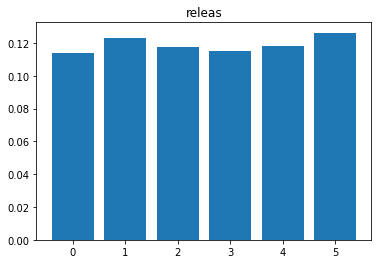

In [ ]:
topic_totals = sentence_topics[['topic', 'normalized']].groupby('topic').aggregate(sum).reset_index()
normalizer = 1 / topic_totals['normalized']
# plt.bar(topic_totals['topic'], topic_totals['normalized'] * normalizer)

def plot_sentence_matches(match_indices):
  subset = sentence_topics.reset_index(drop=True)[
    np.where(dtm_binary_sparse[:,match_indices].sum(axis=1), True, False)[:,0]]
  topic_totals_subset = subset[['topic', 'normalized']].groupby('topic').aggregate(sum).reset_index()
  topic_totals = sentence_topics[['topic', 'normalized']].groupby('topic').aggregate(sum).reset_index()

  topic_totals_subset = topic_totals_subset.merge(topic_totals, on='topic')
  topic_totals_subset['normalized'] = topic_totals_subset['normalized_x'] / topic_totals_subset['normalized_y']

  plt.bar(topic_totals_subset['topic'], topic_totals_subset['normalized'])

def find_plot_sentence_matches(pattern, words):
  match_indices = find_sentence_matches(pattern, words)
  plot_sentence_matches(match_indices)
  plt.title(pattern)
  plt.show()

find_plot_sentence_matches('violen', words)
find_plot_sentence_matches('nonviol', words)
find_plot_sentence_matches('judge', words)
find_plot_sentence_matches('home_confin', words)
find_plot_sentence_matches('releas', words)

## Topics within stories

In [ ]:
story_topic_sentences = copy.deepcopy(sentence_topics).drop(
    ['sentence', 'sentence_id', 'sentence_count'], axis=1)
story_topic_sentences = story_topic_sentences.pivot_table(
  index=['stories_id', 'publish_date'],columns='topic',
  values='normalized',fill_value=0, aggfunc='sum').reset_index()

dictionary = dict()
for i in range(topic_model.n_hidden):
  dictionary.update({i : 'topic' + str(i)})

story_topic_sentences = story_topic_sentences.rename(dictionary, axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/_kernel_base.py:516: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1132: Runtim

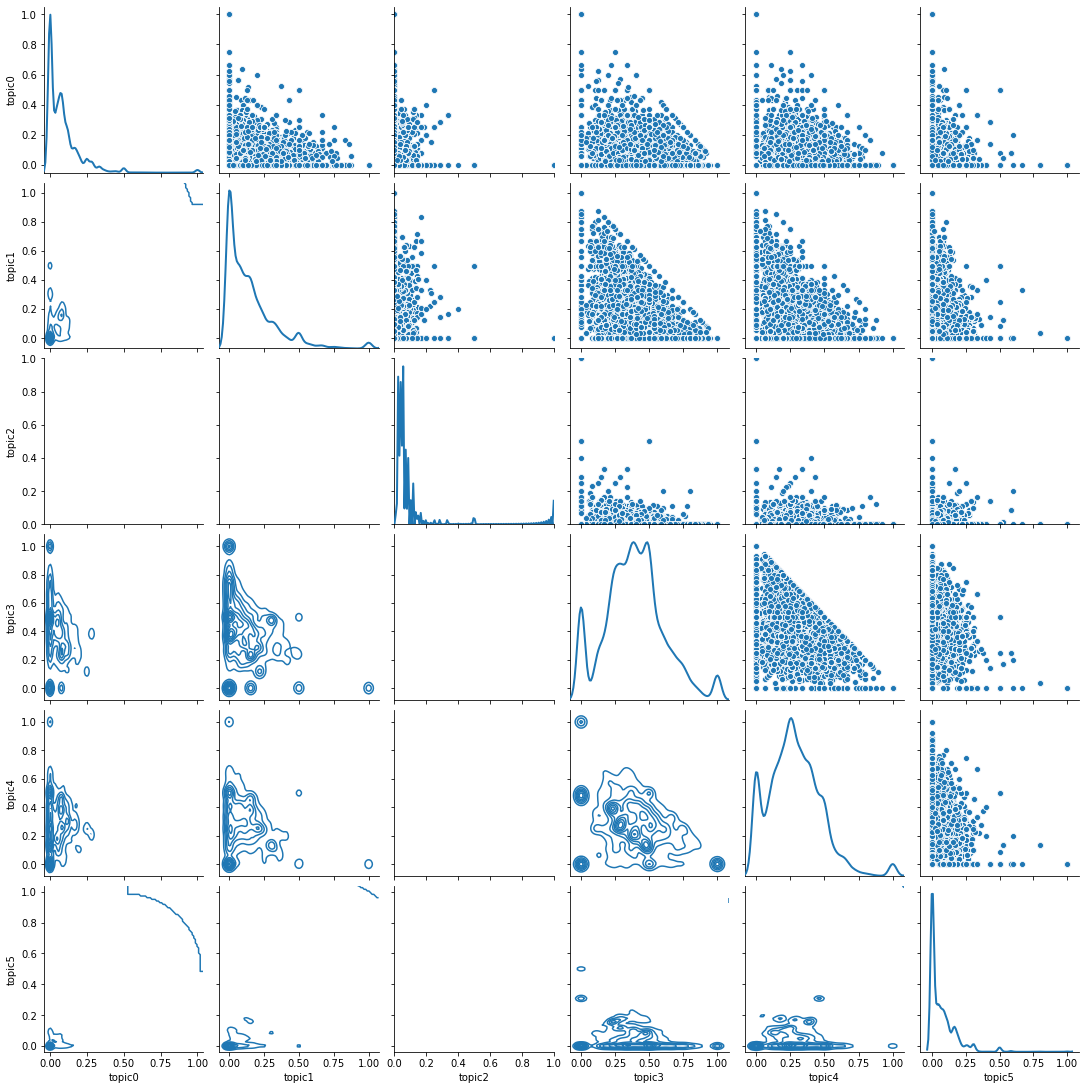

In [ ]:
g = sns.PairGrid(story_topic_sentences[dictionary.values()], diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)
# g.map_lower(sns.heatmap, colors="C0")


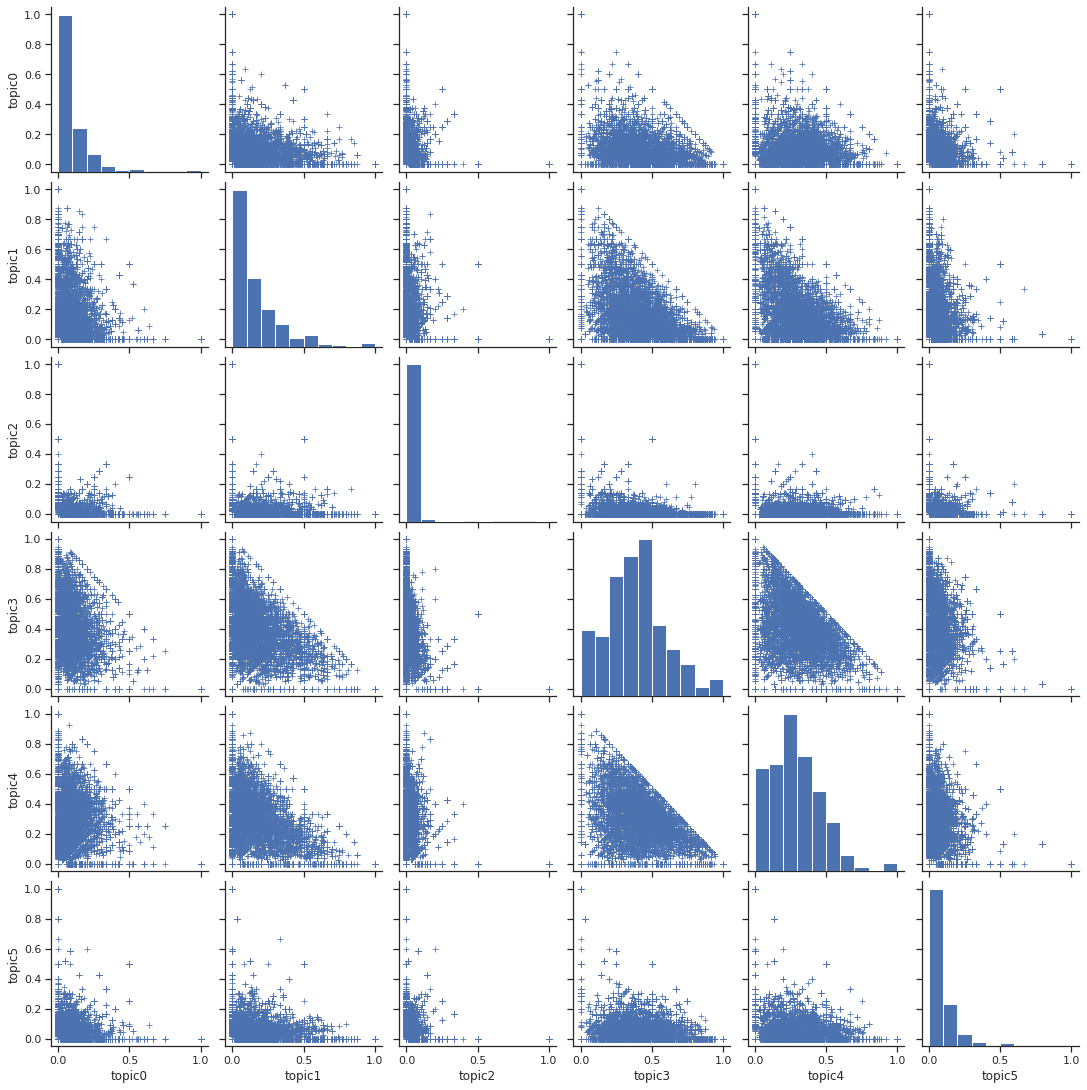

In [ ]:
sns.set(style="ticks")
sns.pairplot(story_topic_sentences[dictionary.values()], markers="+")